## <font size="12"> Imports </font>

In [1]:
import os
from glob import glob
import pickle

import keras
from sklearn.model_selection import train_test_split

from deeplab_mdl_def import DeeplabV3Plus
from utils import *

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
import cv2
from deeplab_mdl_def import DynamicUpsample


from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

2024-04-30 15:06:30.001030: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 15:06:30.032963: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 15:06:30.032989: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 15:06:30.033010: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 15:06:30.038627: I tensorflow/core/platform/cpu_feature_g

## <font size="12">Script parameters </font>

In [2]:
IMAGE_SIZE = 448
BATCH_SIZE = 16
NUM_CLASSES = 14
NUM_EPOCHS = 100
CALCULATE_CLASS_WEIGHTS = False
DATA_DIR = "/homeRepo/tanfoni/faceSegmentation/dataset_paid_integers"

VAL_IMG_FRAC = 0.2
TEST_IMG_FRAC = 0.1
SUBSET = False
SUBSET_SIZE = 240
COLORMAP = patch_colors_bgr_01 = {
    "background": [0, 0, 0],  # BGR
    "generalface": [0.5019607843137255, 0.5019607843137255, 0.5019607843137255],  # BGR
    "left_eye": [0, 1, 0],  # BGR
    "right_eye": [0, 0.5019607843137255, 0],  # BGR
    "nose": [1, 0, 0],  # BGR
    "left_ear": [1, 1, 0],  # BGR
    "right_ear": [0.25098039215686274, 0.25098039215686274, 0],  # BGR
    "lips": [0, 0, 1],  # BGR
    "left_eyebrow": [1, 0, 1],  # BGR
    "right_eyebrow": [0.5019607843137255, 0, 0.5019607843137255],  # BGR
    "hair": [0, 1, 1],  # BGR
    "teeth": [1, 1, 1],  # BGR
    "specs": [0.5019607843137255, 0.5019607843137255, 0],  # BGR
    "beard": [0.7529411764705882, 0.7529411764705882, 1]  # BGR
}
COLORMAP = {key: [color[2], color[1], color[0]] for key, color in COLORMAP.items()}

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"


## <font size="12">Data loading </font>

In [ ]:
all_images = sorted(glob(os.path.join(DATA_DIR, "images/*")))
all_masks = sorted(glob(os.path.join(DATA_DIR, "masks/*")))
# Subset if necessary
if SUBSET:
    all_images = all_images[:SUBSET_SIZE]
    all_masks = all_masks[:SUBSET_SIZE]

# Get number of train, val and test images
NUM_VAL_TRAIN_IMAGES = int((VAL_IMG_FRAC + TEST_IMG_FRAC) * len(all_images))
NUM_VAL_IMAGES = int(VAL_IMG_FRAC * len(all_images))
NUM_TEST_IMAGES = NUM_VAL_TRAIN_IMAGES - NUM_VAL_IMAGES
NUM_TRAIN_IMAGES = len(all_images) - NUM_VAL_TRAIN_IMAGES

train_images, val_images, train_masks, val_masks = train_test_split(all_images, all_masks,
                                                                    test_size=NUM_VAL_TRAIN_IMAGES, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(val_images, val_masks,
                                                                  test_size=NUM_TEST_IMAGES, random_state=42)

print("Train Images: {} | expected: {}".format(len(train_images), NUM_TRAIN_IMAGES))
print("Train Masks: {} | expected: {}".format(len(train_masks), NUM_TRAIN_IMAGES))
print("Val Images: {} | expected: {}".format(len(val_images), NUM_VAL_IMAGES))
print("Val Masks: {} | expected: {}".format(len(val_masks), NUM_VAL_IMAGES))
print("Test Images: {} | expected: {}".format(len(test_images), NUM_TEST_IMAGES))
print("Test Masks: {} | expected: {}".format(len(test_masks), NUM_TEST_IMAGES))

train_dataset = data_generator(train_images,train_masks, BATCH_SIZE)
val_dataset = data_generator(val_images, val_masks, BATCH_SIZE)
test_dataset = data_generator(test_images, test_masks, BATCH_SIZE)
test_dataset_no_resize = data_generator(test_images, test_masks, BATCH_SIZE, augment_data=False, resize_image=False)

## <font size="12">Model definition and training</font>

In [ ]:
if CALCULATE_CLASS_WEIGHTS or not os.path.exists('class_weights.pkl'):
    print("Calculating class weights...")
    class_weights = read_masks_and_compute_weights(os.path.join(DATA_DIR, "masks/"))
    with open('class_weights.pkl', 'wb') as pickle_file:
        pickle.dump(class_weights, pickle_file)
else:
    print("Reloading class weights pickle...")
    with open('class_weights.pkl', 'rb') as pickle_file:
        class_weights = pickle.load(pickle_file)

print("All done, class weights:")
class_weights

## <font size="12">Model training</font>

In [ ]:
model = DeeplabV3Plus(num_classes=NUM_CLASSES)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss = focal_loss_multiclass(alpha=0.25, gamma=2.0)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=loss,
    metrics=["accuracy"],
)
# model.summary()

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS, callbacks=[early_stopping], class_weight=class_weights)




## <font size="12">Model evaluation</font>

In [ ]:
# test for different image sizes
test_loss, test_accuracy = model.evaluate(test_dataset_no_resize)
print(f"Test loss (No resize): {test_loss}, Test accuracy: {test_accuracy}")

In [ ]:
model_name = "deeplabv3plus_face_segmentation_augmentation_class_weights"
model.save(model_name + ".h5")

In [ ]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()


test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


## <font size="12">Inference</font>

(1600, 1200, 3)


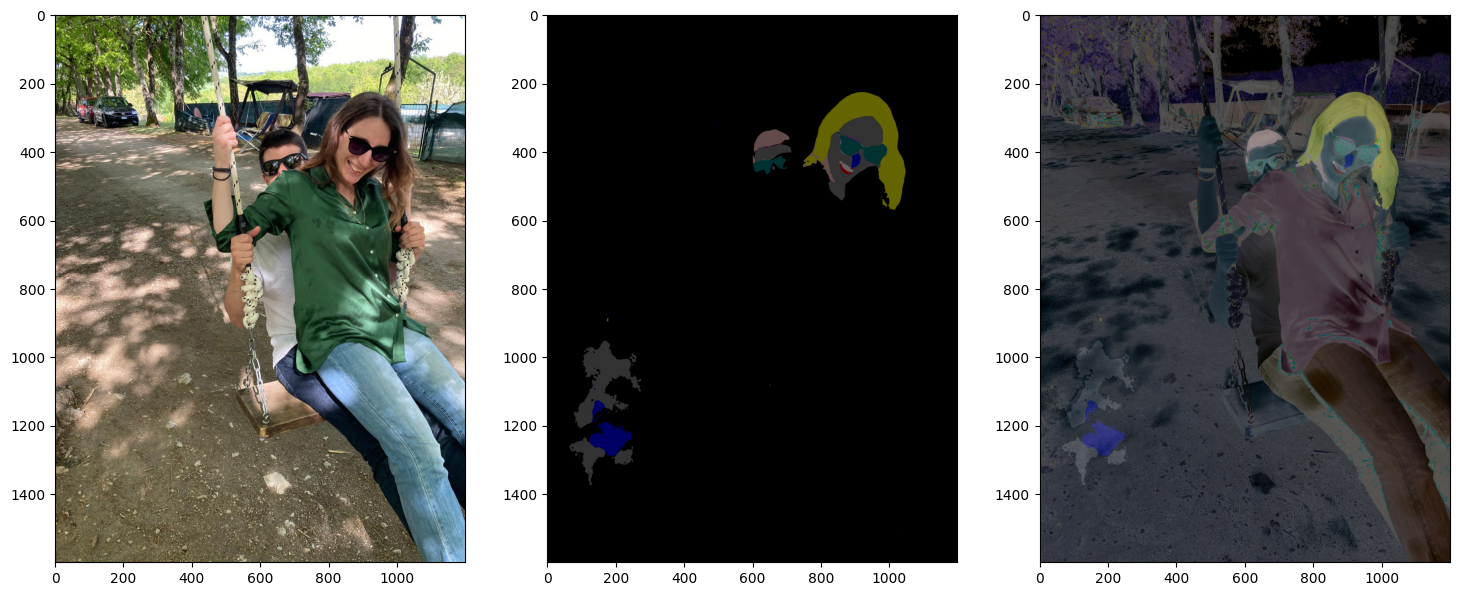

In [4]:
# input_path = "/homeRepo/tanfoni/faceSegmentation/inference/celebahq3.png"
# output_path = "celebahq3_segmented.png"
# 
# img = Image.open(input_path)
# img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
# img_array = np.array(img) / 255.0


# reference_colormap = loadmat("/homeRepo/tanfoni/instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat")["colormap"]
# reference_colormap = reference_colormap*100
# reference_colormap = reference_colormap.astype(np.uint8)
machine = "apophis" # "apophis" or "mec-ai"
if machine == "apophis":
    repo_folder = "/repo/tanfoni/"
elif machine == "mec-ai":
    repo_folder = "/homeRepo/tanfoni/"

def plot_predictions(images_list,image_size, colormap,model, resize=False, n_classes=14):
    for image_file in images_list:
        image = (Image.open(image_file))
        if resize:
            image = image.resize((image_size, image_size))
        image_tensor = np.array(image)
        print(image_tensor.shape)
        prediction_mask = infer(model, image_tensor)
        
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, n_classes=n_classes)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib([image_tensor, prediction_colormap, overlay], figsize=(18,14))
        
# colormap = (np.array([patch for patch in COLORMAP.values()])*100).astype(np.uint8)
model_folder = "Results/Deeplab/models/"
backbone = "resnet50" # "resnet50" or "mobilenetv3"

if backbone == "resnet50":
    model_name = "deeplabv3plus_face_segmentation_pro_Aug_True_2024-04-27_16-04-39/deeplabv3plus_face_segmentation_pro_Aug_True.h5"
elif backbone == "mobilenetv3":
    model_name = "deeplabv3plus_face_segmentation_pro_Aug_True_mobilenetv3_2024-04-28_23-31-01/deeplabv3plus_face_segmentation_pro_Aug_True_mobilenetv3.h5"

#model = keras.models.load_model(model_name +".h5")
model = keras.models.load_model(os.path.join(model_folder, model_name), custom_objects={'DynamicUpsample': DynamicUpsample})
inference_folder_occhi = repo_folder + "test_occhi/prova"
inference_folder_dataset = repo_folder + "Dataset_merged/Test/Fake"
inference_folder_casuali = repo_folder + "faceSegmentation/inference"
inference_folder_occhi_dritte = repo_folder + "faceSegmentation/occhi_frank_dritte"
some_images_to_infer_over = [os.path.join(inference_folder_casuali, f) for f in os.listdir(inference_folder_casuali)
                             if f.endswith(".png")                             
                             or f.endswith(".jpg")
                             or f.endswith(".jpeg")
                             or f.endswith(".bmp")
                             ]
offset = 640
max_imgs = 10


# plot_predictions(some_images_to_infer_over[offset:offset+max_imgs], image_size=IMAGE_SIZE, colormap=COLORMAP, model=model, resize=True)
plot_predictions(some_images_to_infer_over, image_size=IMAGE_SIZE, colormap=COLORMAP, model=model, resize=False
                 )

In [ ]:
plot_predictions(some_images_to_infer_over[:], image_size=IMAGE_SIZE, colormap=COLORMAP, model=model, resize=False)



## <font size="12">Segment dataset</font>
## <font size="5">Dataset must have the structure:</font>

- **Dataset**: 
  - **Train**: 
    - **Real**: 
    - **Fake**: 
  - **Test**: 
    - **Real**: 
    - **Fake**: 
  - **Valid**: 
    - **Real**: 
    - **Fake**: 

In [ ]:
model_name = "deeplabv3plus_face_segmentation_augmentation_class_weights_latest"

model = keras.models.load_model(model_name +".h5", custom_objects={'DynamicUpsample': DynamicUpsample})

remove_background("/homeRepo/tanfoni/Dataset_merged/",
                "/homeRepo/tanfoni/Dataset_deeplab/",
                model, IMAGE_SIZE,
                close_iterations=0,
                erode_iterations=0)